<a href="https://colab.research.google.com/github/johanhoffman/DD2363_VT24/blob/Widen00-Lab3/Lab3/Widen00_lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 3: Approximations**
**Joel Widén**

# **Abstract**



```
# This is formatted as code
```

Short summary of the lab report. State the objectives, methods used, main results and conlusions.

#**About the code**

A short statement on who is the author of the file, and if the code is distributed under a certain license.

# **Set up environment**

In [2]:
# Load neccessary modules.
from google.colab import files

import time
import numpy as np

#try:
#    from dolfin import *; from mshr import *
#except ImportError as e:
#    !apt-get install -y -qq software-properties-common
#    !add-apt-repository -y ppa:fenics-packages/fenics
#    !apt-get update -qq
#    !apt install -y --no-install-recommends fenics
#    from dolfin import *; from mshr import *

#import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt
from matplotlib import tri
from matplotlib import axes
from mpl_toolkits.mplot3d import Axes3D

# **Introduction**

1. Function: L2 projection to pw linear approximation over mesh in 1D

Input: function f(x), 1D mesh with nodes (x0,...,xn)
Output: vector of L2 projection of f(x) evaluated in (x0,...,xn)
Test: verify accuracy and convergence rate against exact function

# **Method**

[-0.5   -0.375  0.     0.     0.     0.     0.     0.     0.   ]
[-0.5  -0.75 -0.25  0.    0.    0.    0.    0.    0.  ]
[-0.5   -0.75  -0.5   -0.125  0.     0.     0.     0.     0.   ]
[-0.5  -0.75 -0.5  -0.25  0.    0.    0.    0.    0.  ]
[-0.5   -0.75  -0.5   -0.25   0.     0.125  0.     0.     0.   ]
[-0.5  -0.75 -0.5  -0.25  0.    0.25  0.25  0.    0.  ]
[-0.5   -0.75  -0.5   -0.25   0.     0.25   0.5    0.375  0.   ]
[-0.5  -0.75 -0.5  -0.25  0.    0.25  0.5   0.75  0.5 ]
[-2.28865979e+00 -1.42268041e+00 -1.02061856e+00 -4.94845361e-01
  1.38777878e-17  4.94845361e-01  1.02061856e+00  1.42268041e+00
  2.28865979e+00]


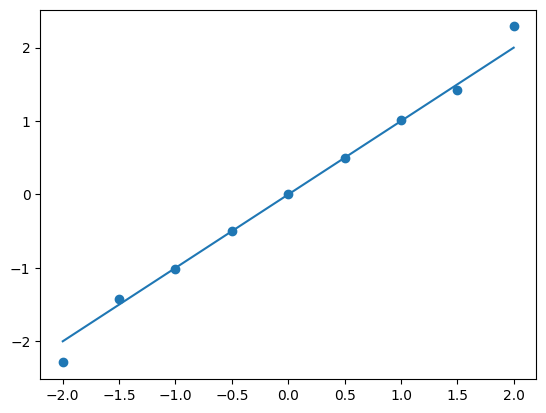

In [48]:
#L2 projection on pw to linear approximation over mesh in 1D


class loc2globmap:
  def __init__(self, A_map, b_map, dof):
    self.A_map = A_map
    self.b_map = b_map
    self.dof = dof

#Reference function
def f(x):
  fx = x
  return fx

#Input x, interval nr k, mesh and if it is the 0 or 1 polynomial in nr
def lin_lagrange_pol(x, mesh, k, nr):
  x_k = mesh[k+1]
  x_k_m1 = mesh[k]
  h_k = x_k - x_k_m1
  if nr == 0:
    lambdax =  (x_k - x)/h_k
  else:
    lambdax = (x- x_k_m1)/h_k
  return lambdax

def get_no_local_shape_functions(k):
  #since we have a linear basis V, q is 2 for all elements
  q = 2
  return q

#Define the local to global maps
def get_local_to_global_map(k):
  A_map = np.array([[k, k+1],[k,k+1]])
  b_map = np.array([k,k+1])
  dof = np.array([k,k+1])
  loc2glob = loc2globmap(A_map, b_map, dof)
  return loc2glob

#Integrating the vector using trapezoidal rule
def integrate_vector(f, k, i, mesh):
  a = mesh[k]
  b = mesh[k+1]
  # Trapezoidal rule
  bi = f(a)*lin_lagrange_pol(a, mesh, k, i)*0.5*(b-a) + f(b)*lin_lagrange_pol(b, mesh, k, i)*0.5*(b-a)
  return bi

def integrate_matrix(k, i, j,mesh):
  #For constant mesh distance hk is the same for all
  hk = mesh[k+1]-mesh[k]
  if i == j:
    aij = hk/3
  else:
    aij = hk/6
  return aij

def add_to_global_vector(b, b_k, loc2glob):
  b[loc2glob.b_map[0]:loc2glob.b_map[1]+1] = b[loc2glob.b_map[0]:loc2glob.b_map[1]+1] + b_k
  return b

def add_to_global_matrix(A, a_k, loc2glob):
  A[loc2glob.A_map[0][0]:loc2glob.A_map[0][1]+1, loc2glob.A_map[1][0]:loc2glob.A_map[1][1]+1] = A[loc2glob.A_map[0][0]:loc2glob.A_map[0][1]+1, loc2glob.A_map[1][0]:loc2glob.A_map[1][1]+1] + a_k
  return A

#From algorithm 9.2
def assembly_system(f, A, b, mesh):
  no_elements = len(b)-1
  for k in range(0, no_elements):
    q = get_no_local_shape_functions(k)
    loc2glob = get_local_to_global_map(k)
    b_k = np.zeros(q)
    a_k = np.zeros((q, q))
    for i in range(0, q):
      b_k[i] = integrate_vector(f, k, i, mesh)
      for j in range(0, q):
        a_k[i, j] = integrate_matrix(k, i, j, mesh)
    b = add_to_global_vector(b, b_k, loc2glob)
    print(b)
    A = add_to_global_matrix(A, a_k, loc2glob)
    #print(A)
  return A, b


#Get coordinates from
def coordinates(A, b):
  A_inv = np.linalg.inv(A)
  alpha = A_inv.dot(b)
  return alpha

def find_subinterval(x, mesh):
  for i in range(0, len(mesh)):
    if mesh[i]<= x <mesh[i+1]:
      k = i
  return k

def get_local_dofs(alpha, loc2glob):
  #beta =

  return beta

def eval_pwp_function(alpha, x, q, mesh):
  k = find_subinterval(x, mesh)
  loc2glob = get_local_to_global_map(k)
  #beta = get_local_dofs(alpha, loc2glob)

  return f

#Performing function of linear projection
def l2_to_pw(f, mesh):
  A = np.zeros((len(mesh), len(mesh)))
  b = np.zeros(len(mesh))

  #Assemble
  A, b = assembly_system(f, A, b, mesh)
  #Get alpha coordinates
  alpha = coordinates(A, b)
  print(alpha)
  #Projection of mesh points
  l2_to_pw = np.zeros_like(mesh)
  for i in range(0, len(alpha)):
    x = mesh[i]
    q = 1
    #l2_to_pw[i] = eval_pwp_function(alpha, x, q, mesh)
  return l2_to_pw, alpha


x_n = 2
interval = 0.5
mesh = np.arange(-2 ,x_n+interval, interval)

f_approx, alpha = l2_to_pw(f, mesh)

plt.figure(1)
plt.plot(mesh, f(mesh))
plt.scatter(mesh, alpha)

plt.show()


# **Results**

# **Discussion**